# Bem vindo ao Music Bot!

<img style="float: left;" src="imagens/music_bot.png">
<br>

### Este é o seu assistente musical!

<p>Ele lista as principais músicas da sua banda ou artista favorito e faz <br>uma análise musical dos principais temas e notas musicais que seu ídolo canta e toca!</p> 
Let´s sing!


## Importação das bibliotecas que serão utilizadas
O primeiro passo será a importação de todas as bibliotecas que o assistente precisa. Estas bibliotecas permitem que o assistente faça requisições à API de músicas, acesse sites para colher informações que não foram disponibilizadas na API, apresente gráficos, aplique limpeza de dados nas letras das músicas e, claro, consiga interagir com o uusário.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import requests
import json
from bs4 import BeautifulSoup
from ipywidgets import interact, widgets  
from IPython.display import Image, display
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Weslley\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Define uma API Key
O Music Bot utiliza a API do Vagalume para buscar informações sobre bandas e músicas. Vagalume é um site Brasileiro que possui um catálogo de artistas e músicas nacionais e internacionais. Você pode consultar mais informações em www.vagalume.com.br.

In [6]:
# Para este endpoint é necessário usar uma API KEY
#apikey = '6e71dd78e117e6c05ce7f1d7fd7c1a9b'
apikey = 'cole_aqui_sua_api_key'

## Configura os idiomas que o Music Bot entende

In [7]:
# Cria uma mapa de idiomas para aplicar stopwords mais adequado
map_language = {1: 'portuguese', 2: 'english', 3: 'spanish'}

## Cria uma função para limpar as letras das músicas
Utilizamos esta função para limpar as letras de músicas que o assistente conseguiu identificar. Este processo de limpeza é importante porque, ao final do processo, queremos construir um gráfico que exibe as principais palavras que o artista utiliza em suas músicas. Em letras de músicas existem muitas stop words, pontuação, eventualmente trechos não alfabéticos ou palavras com uma letra só. Idealmente temos que limpar estes trechos para que nossa nuvem de palavras apresente apenas as palavras mais relevantes da discografia do artista. 

In [8]:
def clean_text(text, l):
        
    # Seta o idioma da letra
    language = map_language.get(l, None)
    
    # Separa as palavras (tokens) sempre que encontrar um espaço em branco
    tokens = text.split()
    
    # Remove pontuação
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    # Remove tokens não alfabéticos
    tokens = [word.strip() for word in tokens if word.isalpha()]
    
    # Remove tokens com um caracter ou menos
    tokens = [word for word in tokens if len(word) > 1]
    
    # Remove stop words
    if language != None:
        stopword_list = nltk.corpus.stopwords.words(language)    
        tokens = [token for token in tokens if token not in stopword_list]
    else:
        print("Não foi possível aplicar stop words porque o idioma desta música é desconhecido pelo assistente")

    # Retorna para o formato de texto
    text_clean = ' '.join(tokens)
    
    # Retorna a letra da música após limpeza
    return text_clean

## Confirme o nome do seu artista ou banda!
O trabalho do assistente começa aqui. No primeiro passo é solicitado ao usuário que informe o nome do artista ou banda que deseja pesquisar. O assistnete fará uma consulta ao endpoint de pesquisa (https://api.vagalume.com.br/search.art) informanda o nome digitado pelo usuário.

Cada artista (or banda) encontrada pelo assistent possui um nome e uma URL. O assistente organizará esta informação em uma lista de tuplas e solicitará ao usuário que confirme o nome da banda ou artista antes de prosseguir. Assim que o usuário confirma a pesquisa (escolhendo uma das opções da caixa de seleção), o assistente acessa um segundo endpoint para exibir a foto da banda (https://www.vagalume.com.br/{}/index.js)

*Note: às vezes não é possível encontrar uma foto da banda ou artista (foto não existe ou a URL da foto é inválida)*

In [10]:
# Captura o nome do artista digitado pelo usuário
name_artist = input("Digite o nome da sua banda ou artista favorito!")

# Faz uma requisição à API para pesquisar por nome de artista
url = "https://api.vagalume.com.br/search.art"
querystring = {"q":name_artist, "limit": "10"}
response = requests.request("GET", url, params=querystring)
response_search = response.json()

# Prepara uma lista de artistas com o resultado da busca
artist_list = response_search['response']['docs']
artist_list = [(a['band'], a['url']) for a in artist_list]

# Monta uma select box para o usuário confirmar o nome do artista
url_artist = widgets.Text()
url_artist_small = widgets.Text()
def confirm_selection(options):
    
    # Busca mais informações sobre o artista
    url = "https://www.vagalume.com.br{}index.js".format(options)
    response = requests.request("GET", url)
    response_artist = response.json()
    url_artist.value = url
    url_artist_small.value = options

    # Exibe uma foto do artista (se existir)
    display(Image(url= "https://www.vagalume.com.br{}".format(response_artist['artist']['pic_medium'])))

interact(confirm_selection, options=artist_list);

Digite o nome da sua banda ou artista favorito! Michael


interactive(children=(Dropdown(description='options', options=(('Michael Jackson', '/michael-jackson/'), ('Mic…

## Pesquisando as músicas mais famosas do seu artista
Esta talvez seja a etapa mais trabalhosa para o assistente. Para cada music_id encontrado anteriormente no perfil do artista, o assistente fará uma busca em um terceiro endpoint (https://api.vagalume.com.br/search.php), informando o music_id, para buscar a letra da música. Esta informação é armazenada no próprio perfil do artista (response_artista).

Importante: Segundo as diretrizes de uso da API do Vagalume, quado muitas requisições à mesma informação são feitas de um mesmo endereço IP, pode ser que a API rejeite as novas tentatias de acesso (em geral, não é possível solicitar a discografia do mesmo artista mais de 3x). Caso isso aconteça, por favor, escolha outro artista ou volte mais tarde. 

In [11]:
# Busca o perfil do artista selecionado
response = requests.request("GET", url_artist.value)
response_artist = response.json()
    
# Faremos um loop nas top musics do artista e, para cada música, vamos buscar a letra em um outro endpoint
top_musicas = []
number_musics = len(response_artist['artist']['toplyrics']['item'])

# Se nenhuma música foi encontrada
if number_musics == 0:
    print ('Desculpe, não conheço nenhuma música do seu artista :(\nEscolha outro!')
    
# Caso contrário, executa a pesquisa
else:
    for musica in response_artist['artist']['toplyrics']['item']:
        
        # Tenta usar a API
        try:
            url = "https://api.vagalume.com.br/search.php"
            querystring = {"musid":musica['id'], "apikey": apikey}
            response = requests.request("GET", url, params=querystring)
            response_music = response.json()
        
        # Se não conseguir, avisa o usuário
        except:
            print("Opss, não foi possível buscar as letras de músicas :( \nPor favor, tente mais tarde ou altere o nome do artista")
            break
        
        # Busca a letra da música
        musica['letra'] = response_music['mus'][0]['text']
        musica['letra_clean'] = clean_text(response_music['mus'][0]['text'], response_music['mus'][0]['lang'])
        musica['url_letra'] = response_music['mus'][0]['url']

        # Algumas letras não possuem tradução. Se este for o caso, seta None
        try:
            musica['letra_traduzida'] = response_music['mus'][0]['translate'][0]['text']
            musica['url_letra_traduzida'] = response_music['mus'][0]['translate'][0]['url']
        except:
            musica['letra_traduzida'] = None
            musica['url_letra_traduzida'] = None

## Salvando um arquivo com as letras das músicas
Nesta etapa estamos criando um arquivo JSON com as principais músicas da sua banda. Caso a letra origimal da música não seja em Português, uma versão traduzida também será disponibilizada.

In [12]:
with open('catalogo_musicas.json', 'w') as file:
    json.dump(response_artist['artist']['toplyrics']['item'], file)

## O que o seu artista preferido mais canta!
Finalmente será exibido uma gráfico com as palavras ou frases mais cantadas pelo seu artista ou banda!

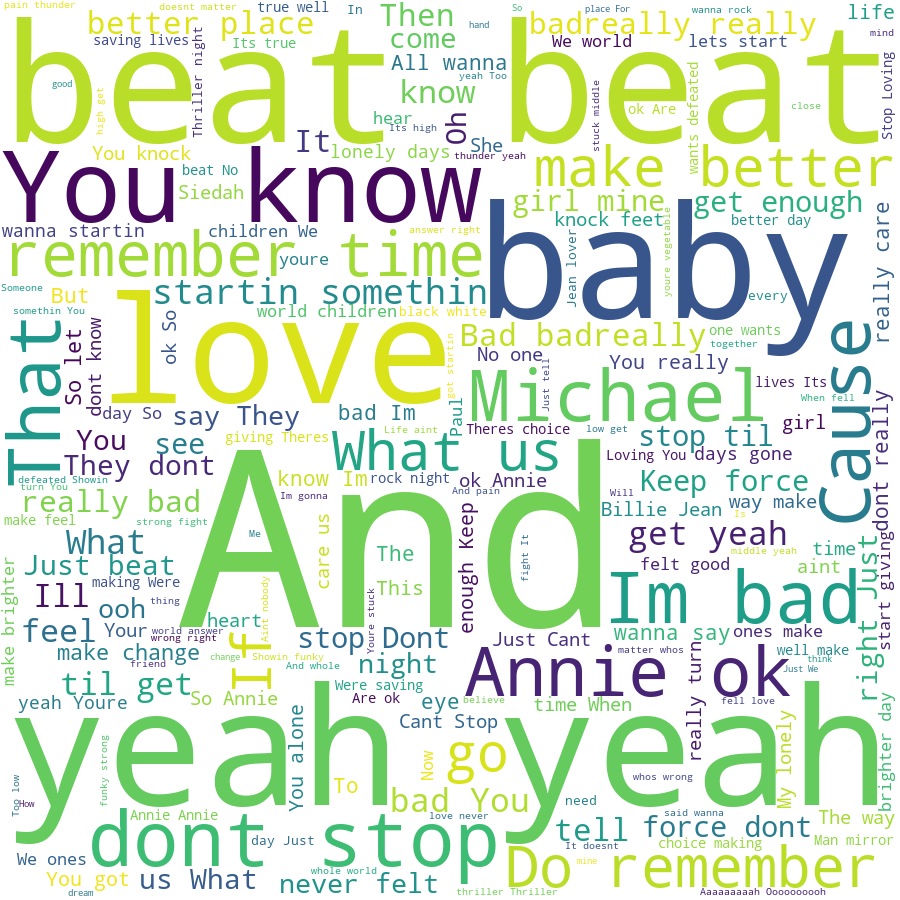

In [13]:
# Junta todas as letras das top musics do seu artista
text = " ".join(musica['letra_clean'] for musica in response_artist['artist']['toplyrics']['item'])

# Monta um word cloud dessas músicas
grafico = WordCloud(background_color="white", max_words=200, width=900, height=900, random_state=1).generate(text)
grafico.to_image()

## Vamos cantar?
Aqui o assistente disponibiliza uma lista de músicas e links da sua banda. Você pode acessar o link e escutá-las!

In [14]:
# Lista as principais músicas
music_list = [(a['desc'], a['url']) for a in response_artist['artist']['toplyrics']['item']]

# Monta uma select box para o usuário confirmar o nome da música
def confirm_music(options):
    print("https://www.vagalume.com.br{}".format(options))

interact(confirm_music, options=music_list);

interactive(children=(Dropdown(description='options', options=(('Heal The World', '/michael-jackson/heal-the-w…

## Os principais acordes do seu ídolo!
Infelizmente, a API do Vagalume não possui informações sobre acordes usados nas músicas dos artistas. Porém, o site Cifra Club (https://www.cifraclub.com.br/) possui estas informações! Nesta etapa vamos assumir que o site Cifra Club possui uma URL com o mesmo formato que encontramos na API do Vagalume (domain/nome-artista). As etapas realizados pelo crawler são as seguintes:
1. Acessa a página principal da banda
2. Recolhe os links das músicas disponíveis
3. Acessa cada link de música encontrado
4. Extrai somente as notas musicais de cada música
5. Cria um contador para tabular todas as notas musicais utilizadas em todas as músicas
6. Exibe as notas mais usadas pelo artista

Estas são as notas mais utilizadas pelo seu ídolo!


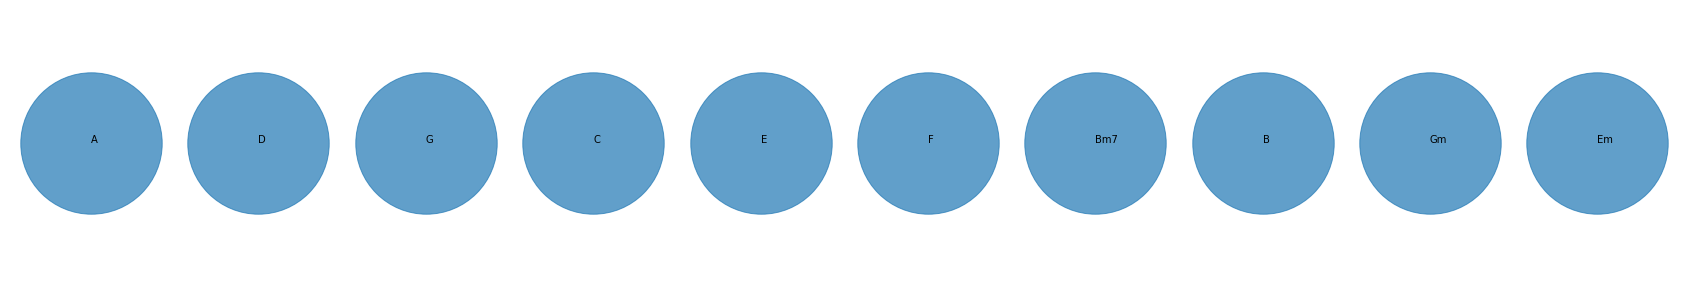

In [15]:
#------------------------------------------------------------------------------------------------------------------------------------
# Etapas 1 e 2
#------------------------------------------------------------------------------------------------------------------------------------

# Acessa a página principal da banda
url_cifraclub = 'https://www.cifraclub.com.br{}'.format(url_artist_small.value)
raw_html = requests.get(url_cifraclub).content
html = BeautifulSoup(raw_html)

# Seleciona todos os links de músicas e letras
all_links = html.find_all("a", class_="art_music-link")

# Mantém apenas os links de músicas
urls = []
for l in all_links:
    url = l.get("href")
    if url.count('/') == 3:
        urls.append(l.get("href"))
        
if urls == []:
    print ("Não consegui encontrar as cifras do seu artista :(")
    
#------------------------------------------------------------------------------------------------------------------------------------
# Etapas 3, 4 e 5
#------------------------------------------------------------------------------------------------------------------------------------

else:
    contagem = dict()
    for url in urls:

        # Acessa a página da música
        url = 'https://www.cifraclub.com.br{}'.format(url)
        raw_html = requests.get(url).content
        html = BeautifulSoup(raw_html)

        # Seleciona a região em que a cifra foi definada
        notas = html.find_all("div", class_="p402_premium songContent")

        # Seleciona apenas as notas musicais
        if notas != []:
            notas = notas[0].find_all("b")
            notas = [nota.get_text() for nota in notas]

            # Faz contagem das notas
            for n in notas:
                contagem[n] = contagem.get(n, 0) + 1

    #------------------------------------------------------------------------------------------------------------------------------------
    # Etapa 6
    #------------------------------------------------------------------------------------------------------------------------------------    

    print ("Estas são as notas mais utilizadas pelo seu ídolo!")
    results = pd.DataFrame.from_dict(contagem, orient='index', columns=['occ']).sort_values(by='occ', ascending=False).head(10)

    fig, ax = plt.subplots(figsize=(30, 5))
    ax.scatter(results.index, [1] * len(results), s=20000, alpha=0.7)

    for i in range(0,len(results)):
        ax.annotate(xy = [i,1], s=results.index[i])
    ax.axis('off')
    plt.show()

## Music Bot Management
Finalizando o processo de pesquisa, nesta última etapa o assistente vai registrar os dados da sua chamada. 

Cria a tabela na qual os registros serão armazenados

In [16]:
# Define o nome do banco de dados
db = 'musicbot.db'

# Query para criar a tabela
query = """ CREATE TABLE IF NOT EXISTS historico_de_pesquisas (
                                    data_requisicao date,
                                    artista text,
                                    url_vagalume text,
                                    url_cifraclub text,
                                    qtd_musicas_vagalume int,
                                    qtd_musicas_cifraclub int
                                ); """

# Conexão com o banco de dados
conn = sqlite3.connect(db)

# Cria um cursor para executar a query
cur = conn.cursor()

# Executa a query
cur.execute(query)

# Fecha a comeão
conn.close()

Insere o registro referente a esta requisição de pesquisa

In [17]:
# Conexão com o banco de dados
conn = sqlite3.connect(db)

# Cria um cursor para executar a query
cur = conn.cursor()

# Define a query
query = """
    INSERT INTO historico_de_pesquisas
    (data_requisicao, artista, url_vagalume, url_cifraclub, qtd_musicas_vagalume, qtd_musicas_cifraclub)
    VALUES (date('now'), '{}', '{}', '{}', {}, {})
"""

# Insere os registros
cur.execute(query.format(url_artist_small.value, url_artist.value, url_cifraclub, len(response_artist['artist']['toplyrics']['item']), len(urls)))

conn.commit()
conn.close()

Confere se o registro foi gravado corretamente

In [18]:
# Conexão com o banco de dados
conn = sqlite3.connect(db)

# Cria um cursor para executar a query
cur = conn.cursor()

query = """
    SELECT * 
    FROM historico_de_pesquisas
"""

cur.execute(query)
results = cur.fetchall()
conn.close()

results

[('2020-06-01',
  '/ana-moura/',
  'https://www.vagalume.com.br/ana-moura/index.js',
  'https://www.cifraclub.com.br/ana-moura/',
  25,
  29),
 ('2020-06-01',
  '/daddy-yankee/',
  'https://www.vagalume.com.br/daddy-yankee/index.js',
  'https://www.cifraclub.com.br/daddy-yankee/',
  25,
  27),
 ('2020-06-01',
  '/tony-carreira/',
  'https://www.vagalume.com.br/tony-carreira/index.js',
  'https://www.cifraclub.com.br/tony-carreira/',
  18,
  27),
 ('2020-06-01',
  '/iggy-pop/',
  'https://www.vagalume.com.br/iggy-pop/index.js',
  'https://www.cifraclub.com.br/iggy-pop/',
  25,
  74),
 ('2020-06-01',
  '/ludmilla/',
  'https://www.vagalume.com.br/ludmilla/index.js',
  'https://www.cifraclub.com.br/ludmilla/',
  25,
  50),
 ('2020-06-01',
  '/michael-jackson/',
  'https://www.vagalume.com.br/michael-jackson/index.js',
  'https://www.cifraclub.com.br/michael-jackson/',
  25,
  135),
 ('2020-06-11',
  '/michael-jackson/',
  'https://www.vagalume.com.br/michael-jackson/index.js',
  'https://

<img src="imagens/music_bot.png" align="left">
<br><br><br><br><br>See you!